In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')

In [2]:
df_AAL = pd.read_csv('../data_nasdaq/data_nasdaq_csv/GOOL.csv')
df_AAL

,Date,Low,Open,Volume,High,Close,Adjusted Close
0,27-09-2005,19.100000,21.049999,961200,21.400000,19.299999,18.194910
1,28-09-2005,19.200001,19.299999,5747900,20.530001,20.500000,19.326204
2,29-09-2005,20.100000,20.400000,1078200,20.580000,20.209999,19.052805
3,30-09-2005,20.180000,20.260000,3123300,21.049999,21.010000,19.807001
4,03-10-2005,20.900000,20.900000,1057900,21.750000,21.500000,20.268940
...,...,...,...,...,...,...,...
4328,06-12-2022,14.000000,14.140000,20781500,14.340000,14.330000,14.330000
4329,07-12-2022,13.530000,14.240000,28161400,14.240000,13.550000,13.550000
4330,08-12-2022,13.380000,13.650000,25300900,13.800000,13.600000,13.600000
4331,09-12-2022,13.420000,13.520000,18489800,13.660000,13.530000,13.530000


In [3]:
df = df_AAL.drop(columns = ['Low', 'High', 'Open', 'Adjusted Close', 'Volume'], axis = 1)

In [4]:
import datetime
def str_to_datetime(s):
    try:
        split = s.split('-')
        day, month, year = int(split[0]), int(split[1]), int(split[2])
        return datetime.datetime(day=day, month=month, year=year)
    except ValueError:
        print(f"Invalid date string: {s}")
        return None
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2005-09-27
1      2005-09-28
2      2005-09-29
3      2005-09-30
4      2005-10-03
          ...    
4328   2022-12-06
4329   2022-12-07
4330   2022-12-08
4331   2022-12-09
4332   2022-12-12
Name: Date, Length: 4333, dtype: datetime64[ns]

In [5]:
# Set date as the index
df.index = df.pop('Date')

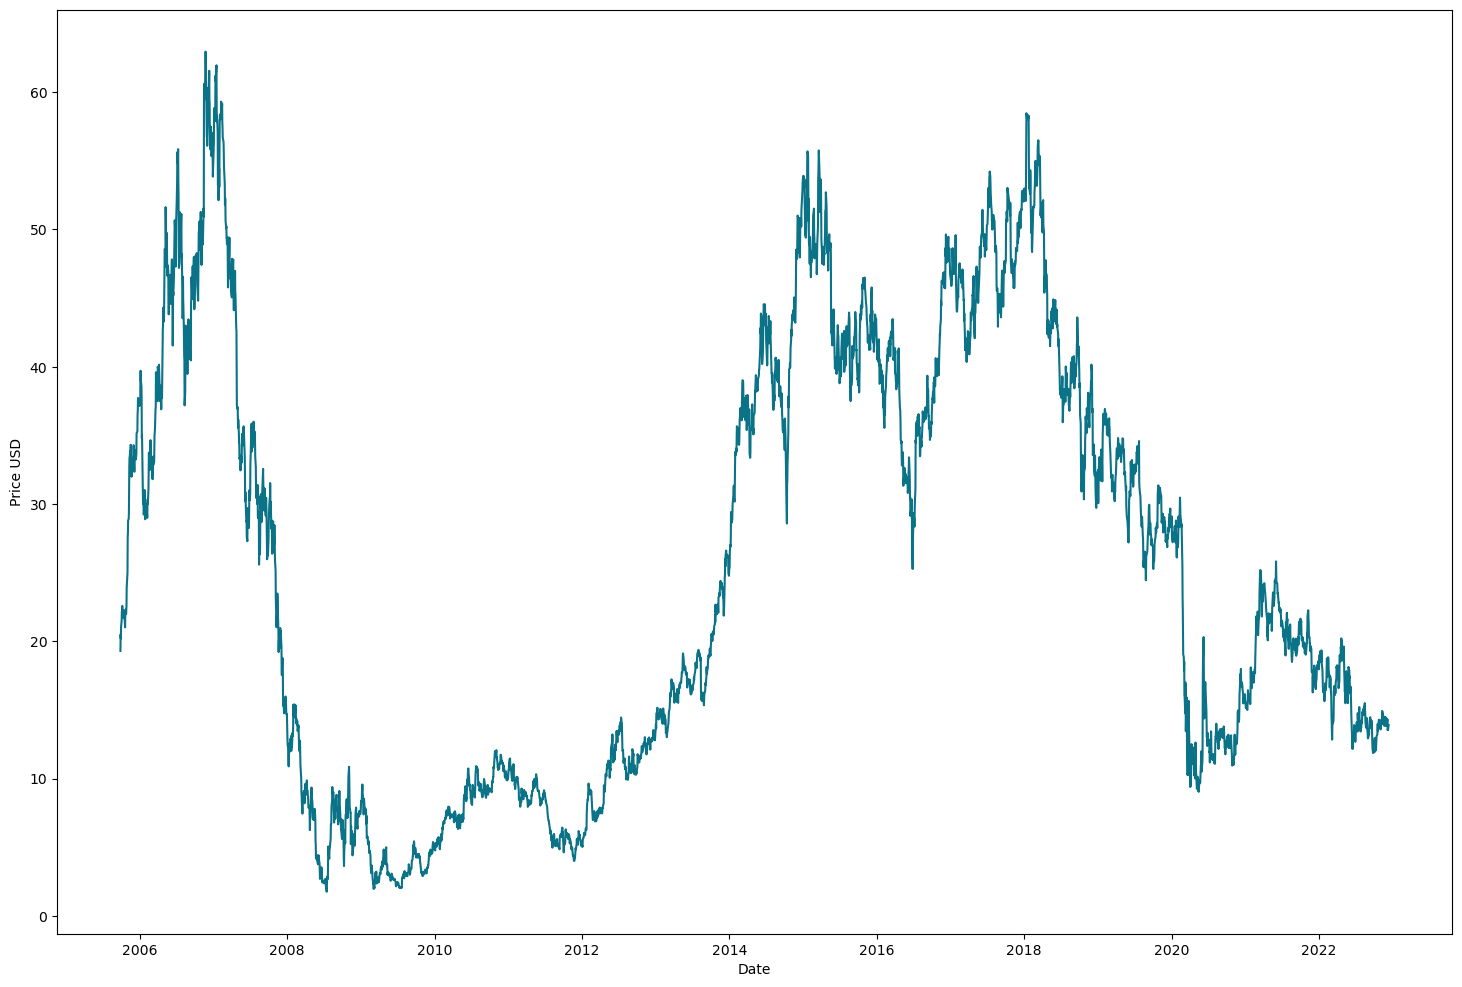

In [6]:
plt.rcParams['figure.figsize'] = (18, 12)

def price(x):
    """
    format the coords message box
    :param x: data to be formatted
    :return: formatted data
    """
    return '$%1.2f' % x

fig, ax = plt.subplots()
ax.plot(df.index, df['Close'], '#0A7388')
ax.format_ydata = price
# Add labels
plt.ylabel("Price USD")
plt.xlabel("Date")

plt.show()

In [7]:
### Split the dataset into time windows to get data samples.

# df = data_appl
X_data = []
y_data = []
dates = []
window_size = 30 # Time window for data feature (size of 'number of days') to learn.

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df) - window_size - 1):
    first = df.iloc[i, 0]
    data_feature = []
    data_label = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_feature.append(df.iloc[i + j, 0])
        
    # Next value is the label (price of the next day) to be predicted
    data_label.append(df.iloc[i + window_size, 0])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data.append(np.array(data_feature).reshape(window_size, 1))
    y_data.append(np.array(data_label))
    dates.append(df.iloc[i + window_size, :].name)


In [8]:
len(X_data), len(y_data), len(dates)

(4301, 4301, 4301)

In [9]:
from helper_functions import data_preprocessing as pp
X_train, y_train, X_val, y_val, X_test, y_test, train_dates, val_dates, test_dates = pp.split_dataset(X_data, y_data, dates)

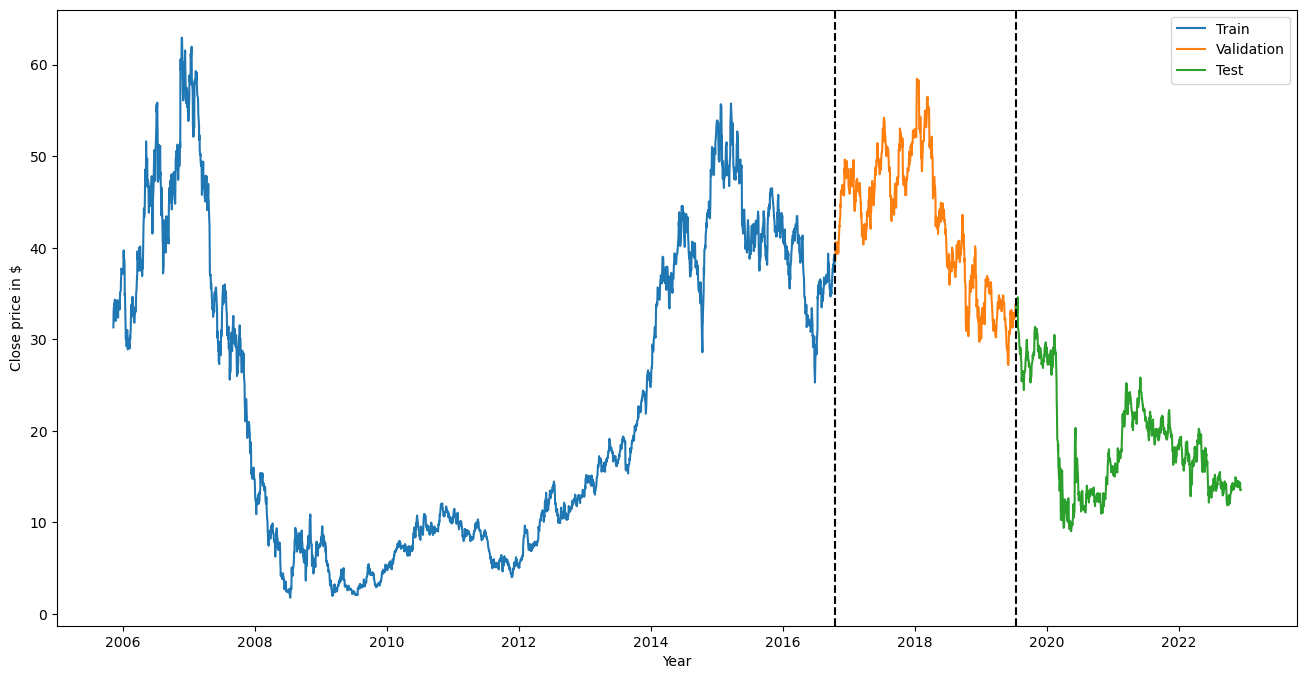

In [10]:
# Visualize the training, validation and test set
fig, ax = plt.subplots(figsize = (16,8))
df_plot = df['Close']
df_plot = df_plot.reset_index(drop=False)
plt.plot(train_dates, y_train)
plt.plot(val_dates, y_val)
plt.plot(test_dates, y_test)
plt.xlabel('Year')
plt.ylabel('Close price in $')
plt.legend(['Train', 'Validation', 'Test'])

# Add vertical lines to separate training, validation, and test sets
plt.axvline(x=train_dates[-1], color='k', linestyle='--')
plt.axvline(x=val_dates[-1], color='k', linestyle='--')

plt.show()


In [11]:
# Normalize data
X_train_norm, y_train_norm = pp.normalize_data(X_train, y_train)
X_val_norm, y_val_norm = pp.normalize_data(X_val, y_val)
X_test_norm, y_test_norm = pp.normalize_data(X_test, y_test)

In [12]:
### Create and train the model

# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Activation

# Build the model architecture
model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

# Compile and train the model with Mean Squared Error loss function
model.compile(optimizer= Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mean_absolute_error'])
model_training = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=50, batch_size=32)

2023-05-19 19:08:43.323288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
86/86 [==============================] - 4s 22ms/step - loss: 0.0785 - mean_absolute_error: 0.2109 - val_loss: 0.0332 - val_mean_absolute_error: 0.1360
Epoch 2/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0299 - mean_absolute_error: 0.1260 - val_loss: 0.0254 - val_mean_absolute_error: 0.1154
Epoch 3/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0266 - mean_absolute_error: 0.1186 - val_loss: 0.0292 - val_mean_absolute_error: 0.1277
Epoch 4/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0268 - mean_absolute_error: 0.1199 - val_loss: 0.0250 - val_mean_absolute_error: 0.1161
Epoch 5/50
86/86 [==============================] - 1s 14ms/step - loss: 0.0261 - mean_absolute_error: 0.1181 - val_loss: 0.0232 - val_mean_absolute_error: 0.1122
Epoch 6/50
86/86 [==============================] - 1s 12ms/step - loss: 0.0245 - mean_absolute_error: 0.1137 - val_loss: 0.0250 - val_mean_absolute_error: 0.1148
Epoch 7/50
86/86 [====

In [13]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error

# Get prediction on the test data
y_pred_norm = model.predict(X_test_norm)
print("MSE on the test set: ", mean_squared_error(y_pred_norm, y_test_norm))

27/27 [==============================] - 1s 6ms/step
MSE on the test set:  0.04485254440364401


In [14]:
y_pred_norm[1]

array([0.9853281], dtype=float32)

86/86 [==============================] - 0s 5ms/step


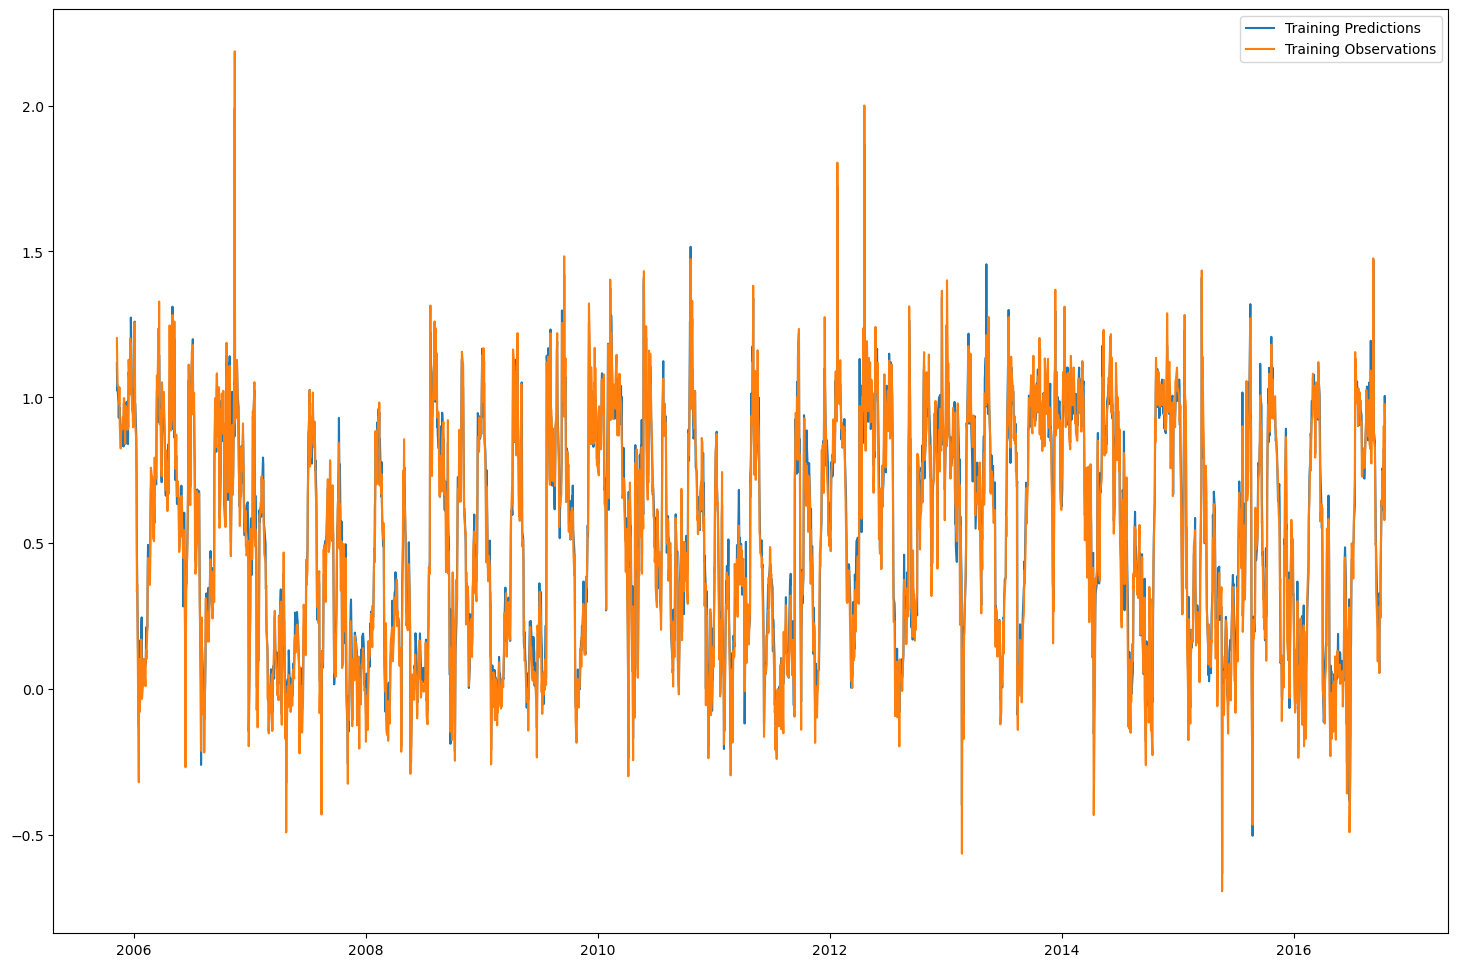

In [15]:
train_predictions = model.predict(X_train_norm).flatten()

plt.plot(train_dates, train_predictions)
plt.plot(train_dates, y_train_norm)
plt.legend(['Training Predictions', 'Training Observations'])

22/22 [==============================] - 0s 4ms/step


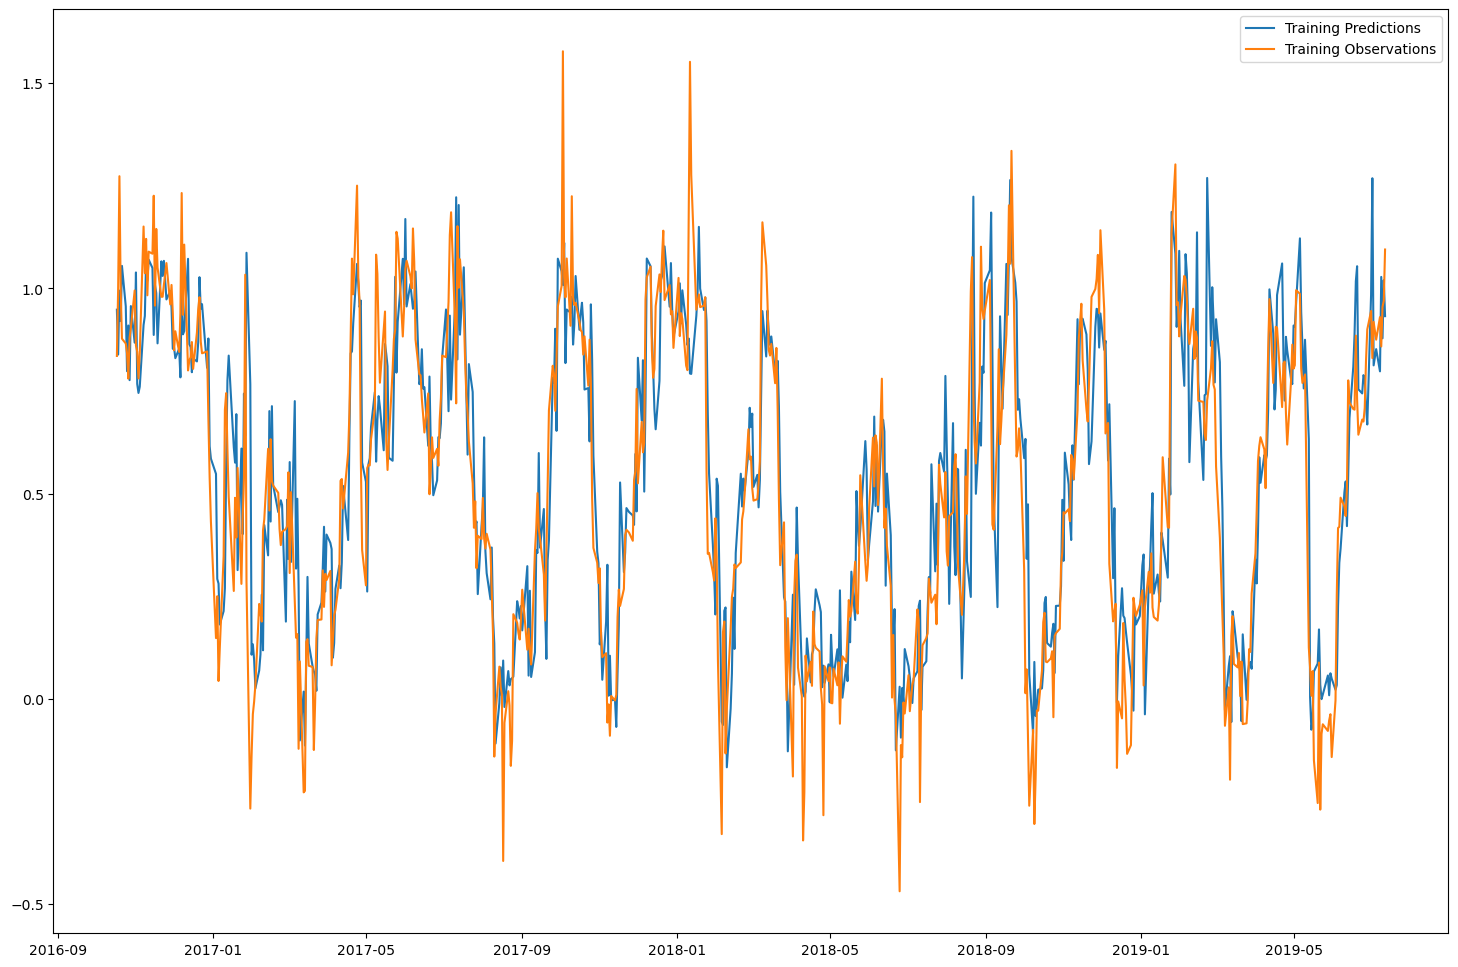

In [16]:
val_predictions = model.predict(X_val_norm).flatten()

plt.plot(val_dates, val_predictions)
plt.plot(val_dates, y_val_norm)
plt.legend(['Training Predictions', 'Training Observations'])

27/27 [==============================] - 0s 5ms/step


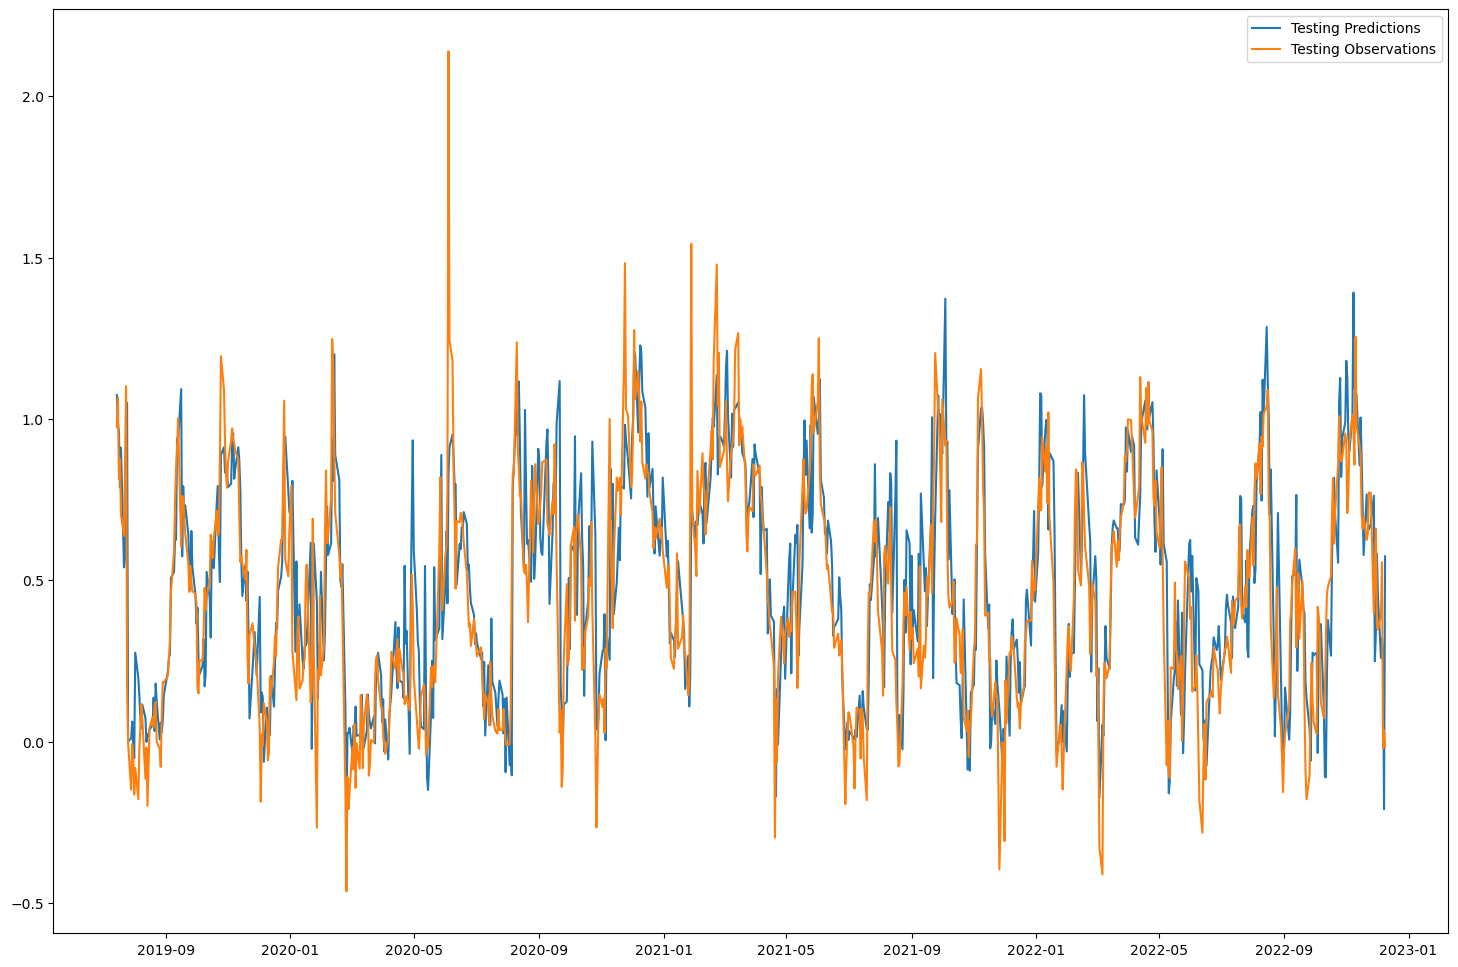

In [17]:
test_predictions = model.predict(X_test_norm).flatten()

plt.plot(test_dates, test_predictions)
plt.plot(test_dates, y_test_norm)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [18]:
# Convert the result back to stock price (i.e., de-normalization) for visualization purpose
y_pred_denorm = y_pred_norm
for i in range(0, len(y_pred_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test[i])
    max_feature = np.max(X_test[i])
    y_pred_denorm[i] = y_pred_norm[i] * (max_feature - min_feature) + min_feature

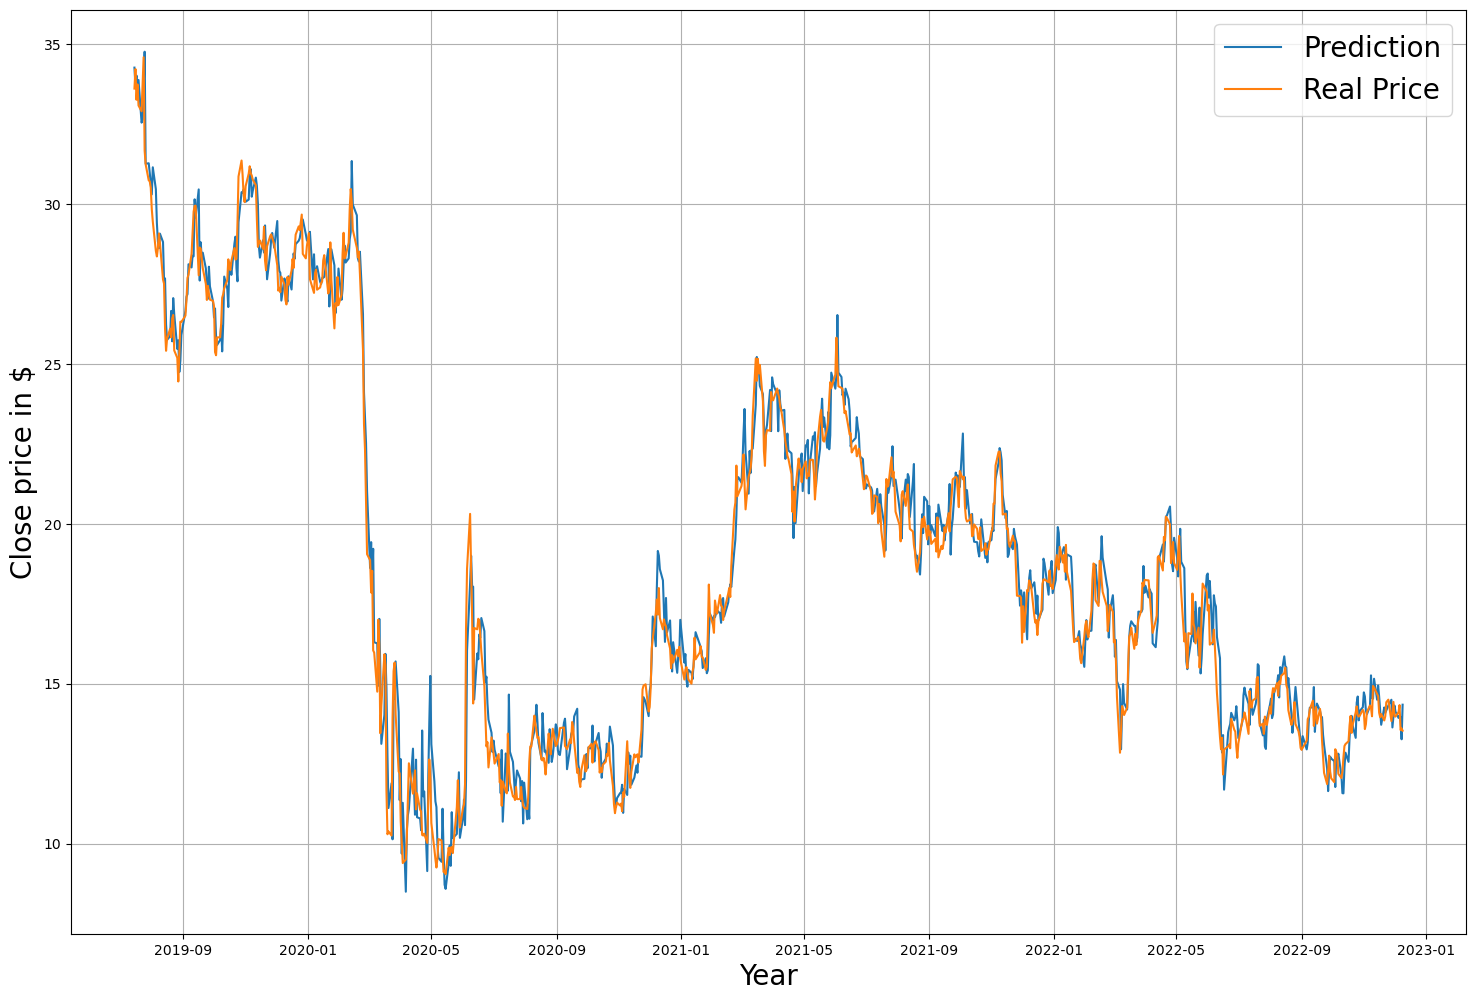

In [19]:

plt.plot(test_dates, y_pred_denorm)
plt.plot(test_dates, y_test)

plt.xlabel('Year', fontsize = 20)
plt.ylabel('Close price in $', fontsize = 20)
plt.legend(['Prediction', 'Real Price'], fontsize = 20)
plt.grid() # Add grid
plt.show()


In [20]:
# from copy import deepcopy

# recursive_predictions = []
# recursive_dates = np.concatenate([val_dates, test_dates])

# for target_date in recursive_dates:
#     last_window = deepcopy(X_train_norm[-1])
#     next_prediction = model.predict(np.array([last_window])).flatten()
#     recursive_predictions.append(next_prediction)
#     last_window[-1] = next_prediction

In [21]:

X_data_1 = []
y_data_1 = []
dates = []
window_size = 30 # Time window for data feature (size of 'number of days') to learn.
forecast_days = 7 # Number of days to forecast

# Only get the open price (index 2 in the data frame)
for i in range(1, len(df) - window_size - forecast_days):
    first = df.iloc[i, 0]
    data_features = []
    data_labels = []
    
    # Get a window_size time frame for data feature
    for j in range(window_size):
        data_features.append(df.iloc[i + j, 0])
        
    # Next 7 values are the label (prices of the next 7 days) to be predicted
    for k in range(forecast_days):
        data_labels.append(df.iloc[i + window_size + k, 0])
    
    # Append new data sample (feature and label) to X_data and y_data
    X_data_1.append(np.array(data_features).reshape(window_size, 1))
    y_data_1.append(np.array(data_labels))
    dates.append(df.iloc[i + window_size, :].name)

X_train_1, y_train_1, X_val_1, y_val_1, X_test_1, y_test_1, train_dates, val_dates, test_dates = pp.split_dataset(X_data_1, y_data_1, dates)

# Normalize data
X_train_norm_1, y_train_norm_1 = pp.normalize_data(X_train_1, y_train_1)
X_val_norm_1, y_val_norm_1 = pp.normalize_data(X_val_1, y_val_1)
X_test_norm_1, y_test_norm_1 = pp.normalize_data(X_test_1, y_test_1)

In [22]:
X_train_1[0], y_train_1[0]

(array([[20.5       ],
        [20.20999908],
        [21.01000023],
        [21.5       ],
        [22.15999985],
        [22.20000076],
        [22.57999992],
        [22.14999962],
        [22.20999908],
        [21.97999954],
        [21.76000023],
        [21.70999908],
        [22.27000046],
        [22.07999992],
        [21.48999977],
        [21.37999916],
        [21.02000046],
        [21.95999908],
        [22.30999947],
        [22.        ],
        [22.31999969],
        [22.55999947],
        [23.89999962],
        [24.68000031],
        [25.02000046],
        [27.54999924],
        [27.87000084],
        [28.79999924],
        [28.93000031],
        [29.43000031]]),
 array([31.29999924, 32.79999924, 33.34999847, 33.75      , 33.88000107,
        33.59999847, 34.31999969]))

In [23]:
X_train_norm_1.shape, y_train_norm_1.shape

((2748, 30, 1), (2748, 7))

In [24]:
X_test_norm_1.shape, y_test_norm_1.shape

((859, 30, 1), (859, 7))

In [25]:
# Build the model architecture
model1 = Sequential()
model1.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1), padding='same'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Conv1D(128, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPooling1D(2))
model1.add(Conv1D(64, kernel_size=3, activation='relu', padding='same'))
model1.add(MaxPooling1D(2))
model1.add(Flatten())
model1.add(Dense(100, activation='relu'))
model1.add(Dense(7)) # By default: activation='linear', i.e., passing through f(x) = x

# Compile and train the model with Mean Squared Error loss function
model1.compile(optimizer= Adam(learning_rate=0.001), 
              loss='mse', 
              metrics=['mean_absolute_error'])
model_training1 = model1.fit(X_train_norm_1, y_train_norm_1, validation_data=(X_val_norm_1,y_val_norm_1), epochs=50, batch_size=128)

Epoch 1/50
22/22 [==============================] - 3s 43ms/step - loss: 0.2834 - mean_absolute_error: 0.4293 - val_loss: 0.2116 - val_mean_absolute_error: 0.3513
Epoch 2/50
22/22 [==============================] - 1s 32ms/step - loss: 0.1671 - mean_absolute_error: 0.3161 - val_loss: 0.1498 - val_mean_absolute_error: 0.2768
Epoch 3/50
22/22 [==============================] - 1s 39ms/step - loss: 0.1297 - mean_absolute_error: 0.2649 - val_loss: 0.1164 - val_mean_absolute_error: 0.2411
Epoch 4/50
22/22 [==============================] - 1s 27ms/step - loss: 0.1136 - mean_absolute_error: 0.2424 - val_loss: 0.1115 - val_mean_absolute_error: 0.2344
Epoch 5/50
22/22 [==============================] - 1s 25ms/step - loss: 0.1091 - mean_absolute_error: 0.2362 - val_loss: 0.1110 - val_mean_absolute_error: 0.2360
Epoch 6/50
22/22 [==============================] - 1s 29ms/step - loss: 0.1075 - mean_absolute_error: 0.2343 - val_loss: 0.1076 - val_mean_absolute_error: 0.2316
Epoch 7/50
22/22 [====

In [26]:
### Get prediction on the test data and convert the result back to stock price (i.e., de-normalization)
from sklearn.metrics import mean_squared_error
# Get prediction on the test data
y_pred_norm_1 = model1.predict(X_test_norm_1)
y_pred_norm_1[1]
print("MSE on the test set: ", mean_squared_error(y_test_norm_1[0], y_pred_norm_1[0]))

27/27 [==============================] - 1s 9ms/step
MSE on the test set:  0.13435528520321474


In [27]:
y_pred_norm_1.shape

(859, 7)

In [28]:
# Rescale the predicted prices to the original range
y_pred_denorm_1 = y_pred_norm_1
for i in range(0, len(y_pred_denorm_1)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(X_test_1[i])
    max_feature = np.max(X_test_1[i])
    y_pred_denorm_1[i] = y_pred_norm_1[i] * (max_feature - min_feature) + min_feature

In [29]:
# Get the latest 30-day data to predict for the prices of the next 7 days in the future
latest_30_days = df.iloc[-30:, 0].values.reshape(1, window_size, 1)

# Normalize the latest 30-day data
latest_30_days_norm = latest_30_days.copy()
for i in range(0, len(latest_30_days_norm)):
    min_feature = np.min(latest_30_days[i])
    max_feature = np.max(latest_30_days[i])
    latest_30_days_norm[i] = (latest_30_days[i] - min_feature) / (max_feature - min_feature)
predicted_prices_norm = model1.predict(latest_30_days_norm)

# Use the trained model to predict the prices for the next 7 days
predicted_prices_denorm = predicted_prices_norm
for i in range(0, len(predicted_prices_denorm)): # denorm_x = norm_x * (max(x) - min(x)) + min(x)
    min_feature = np.min(latest_30_days[i])
    max_feature = np.max(latest_30_days[i])
    predicted_prices_denorm[i] = predicted_prices_norm[i] * (max_feature - min_feature) + min_feature

# Print the predicted prices for the next 7 days
print(predicted_prices_denorm)

1/1 [==============================] - 0s 44ms/step
[[13.844968 13.797028 13.811861 13.659643 13.795133 13.803783 14.041447]]


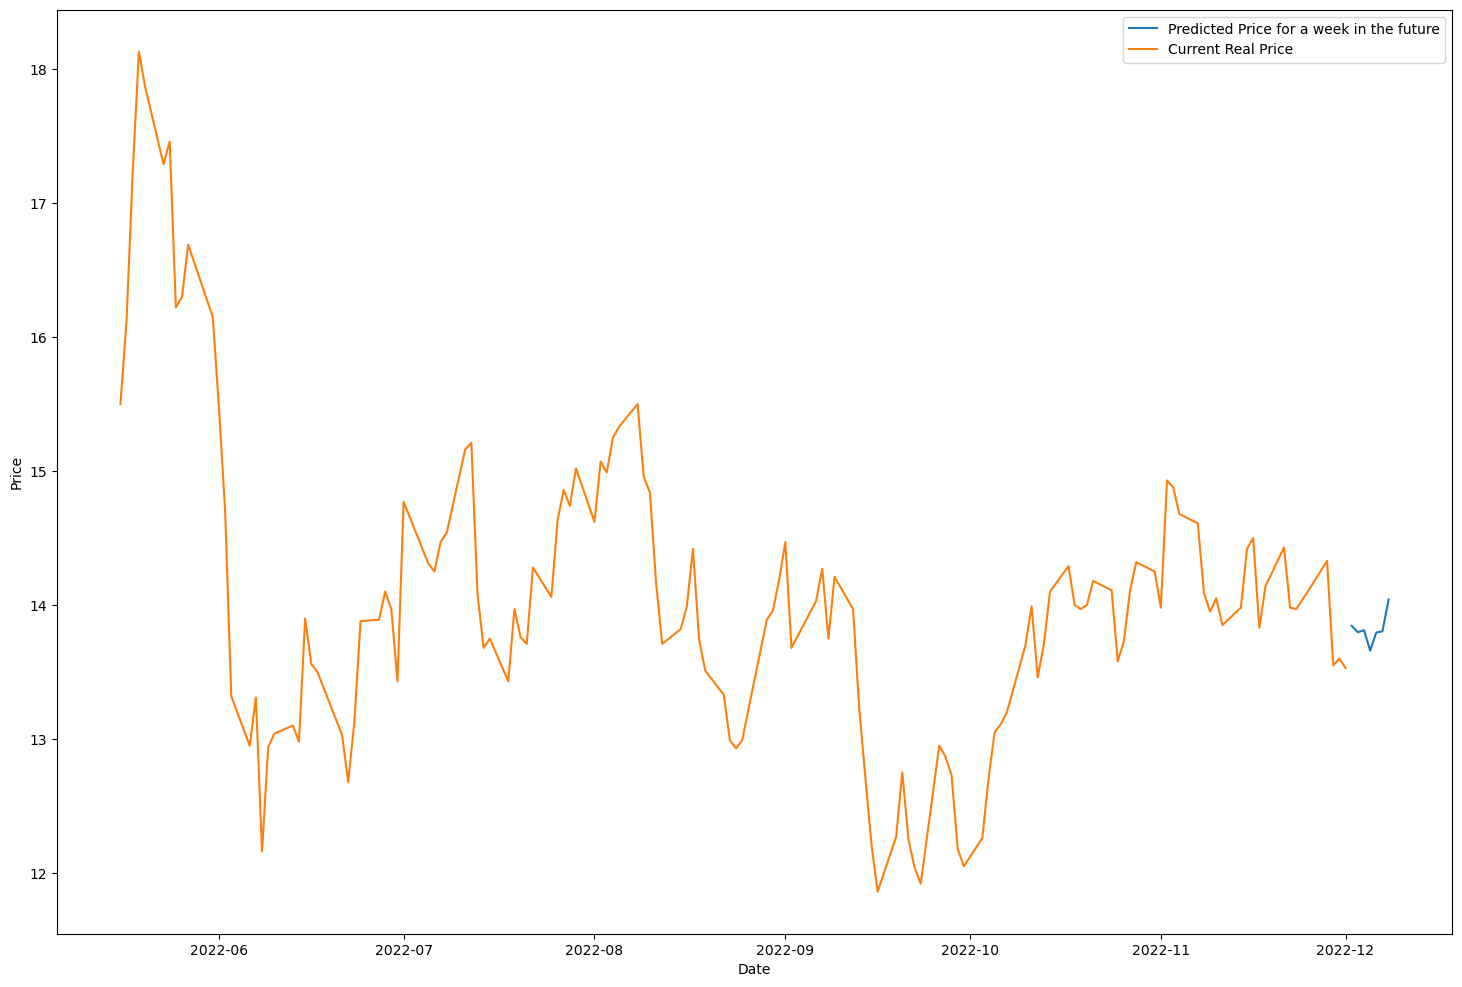

In [30]:
predicted_prices_denorm = predicted_prices_denorm.flatten()
# Select the latest 100 days from the test_dates

test_dates_latest_2years = [d for d in test_dates if d >= test_dates[-1] - datetime.timedelta(days=200)]

# Create a list of the next 7 dates
next_7_dates = [test_dates_latest_2years[-1] + datetime.timedelta(days=x) for x in range(1, 8)]

# Plot the predicted prices in the next 7 days
plt.plot(next_7_dates, predicted_prices_denorm, label = 'Predicted Price for a week in the future')
plt.plot(test_dates_latest_2years, y_test[-len(test_dates_latest_2years):], label = 'Current Real Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()